# Import

In [17]:
from qDrift.hamsimqDrift import AlgorithmHamSimqDrift
from pytket.circuit import Circuit
from openfermion.utils.operator_utils import count_qubits

from utils.func import *
from utils.term_grouping import *
from utils.min_clique import *
from utils.hamlib import *
from utils.evol_real import *
from utils.plot import *
from utils.driver import *
from utils.JW import *

from Pauli_Gadgets.paulis import *

import numpy as np
import matplotlib.pyplot as plt

def gen_sys_param(n=10, sample_steps=100000, N=1):
    global t_max
    global initial_state_circ
    global n_qdrift_steps
    global sample_space
    global seg
    global t_list

    t_list = [1,2,5,8]
    t_max=t_list[-1]
    seg = N
    initial_state_circ = Circuit(n)
    for i in range(n):
        initial_state_circ.H(i)
    n_qdrift_steps = sample_steps
    sample_space = np.arange(0,sample_steps+1,1)

# Hydrogen chain

In [18]:
driver = PySCFDriver_custom()
bond_length = 1.0
n_sites = 3
driver.load_molecule(
    atom=[('H', (0, 0, i * bond_length)) for i in range(n_sites)], # Create a molecular data object for the hydrogen chain
    basis="sto-3g",          # Basis set for quantum chemistry calculation
    multiplicity=1,          # Spin multiplicity for molecule, since the total spin of H2O is S=0，its spin multiplicity is 2S+1=1
    charge=0,                 # Total charge of molecule, since H2O is charge neutral, its charge=0
    unit="Angstrom"
)
driver.run_scf()             # Perform Hartree Fock calculation

# np.set_printoptions(precision=4, linewidth=150)

hpq = driver.get_onebody_tensor("int1e_kin") + driver.get_onebody_tensor("int1e_nuc")
vpqrs = driver.get_twobody_tensor()
# assert np.shape(hpq)==(7, 7)             # H2O has 7 orbitals when using STO-3G basis.
# assert np.shape(vpqrs)==(7, 7, 7, 7)

# print(hpq)
operator = get_molecular_hamiltonian(hpq,vpqrs,driver)
n_qubits = count_qubits(operator)
number, coulomb, hopping, no_excitation, double_excitation = JW_transformation(operator)
numbers, coulombs, hoppings, no_excitations, double_excitations = JW_transformation(operator,True)

number_op, number_co = convert_op_to_input(number,n_qubits)
hopping_op, hopping_co = convert_op_to_input(hopping,n_qubits)
coulomb_op, coulomb_co = convert_op_to_input(coulomb,n_qubits)
no_excitation_op, no_excitation_co = convert_op_to_input(no_excitation,n_qubits)
double_excitation_op, double_excitation_co = convert_op_to_input(double_excitation,n_qubits)

numbers_op, numbers_co = convert_op_to_input(numbers,n_qubits,True)
hoppings_op, hoppings_co = convert_twobody_op_to_input(hoppings,n_qubits,True)
coulombs_op, coulombs_co = convert_op_to_input(list(coulombs),n_qubits,True)
no_excitations_op, no_excitations_co = convert_twobody_op_to_input(list(no_excitations),n_qubits,True)
double_excitations_op, double_excitations_co = convert_twobody_op_to_input(list(double_excitations),n_qubits,True)

# max_part_group = [[number_op[0], number_op[-2],hopping_op[0], hopping_op[1]],number_op[2:4],[number_op[1], number_op[-1], hopping_op[-2],hopping_op[-1]]]+coulombs_op+no_excitations_op+double_excitations_op
# max_coeff = [[(number_co[0]+number_co[-2]+abs(hopping_co[0])*2)/4],[number_co[2]],[(number_co[0]+number_co[-2]+abs(hopping_co[0])*2)/4]]+coulombs_co+no_excitations_co+double_excitations_co
# max_part_group, max_coeff = site_excitation_group(numbers_op,hoppings_op,numbers_co,hoppings_co)

H_matrix = get_Hmatrix(number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,n_qubits,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co)

converged SCF energy = -1.52399620024611


In [19]:
U2p_overall = []
for i in range(3):
    gen_sys_param(n=n_qubits,sample_steps=100)
    drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps,seg,noise=True)
    U2p,secdepth = drift_time_evolution.trotter(order=2, protected=True, cheat=True)
    U2p_overall.append(U2p)

In [20]:
Ut_overall = []
for i in range(3):
    gen_sys_param(n=n_qubits,sample_steps=200)
    drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps,seg,noise=True)
    Ut,ldepth = drift_time_evolution.trotter(cheat=True)
    Ut_overall.append(Ut)

In [21]:
U2_overall = []
for i in range(3):
    gen_sys_param(n=n_qubits,sample_steps=100)
    drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps,seg,noise=True)
    U2,secdepth = drift_time_evolution.trotter(order=2,cheat=True)
    U2_overall.append(U2)

In [8]:
Urp_overall = []
for i in range(3): 
    gen_sys_param(n=n_qubits,sample_steps=100)
    drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps,seg,noise=True)
    Urp,rpdepth = drift_time_evolution.trotter(rand=True,cheat=True)
    Urp_overall.append(Urp)

In [116]:
gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,numbers_op+hoppings_op+coulombs_op+no_excitations_op+double_excitations_op,numbers_co+hoppings_co+coulombs_co+no_excitations_co+double_excitations_co,t_max,n_qdrift_steps,seg,M=3,noise=True)
Um,sm,mdepth = drift_time_evolution.Drift_exp(depth=secdepth[-1],cheat=True)
# Um_overall = []
# Um_overall.append(Um)
# for i in range(2):
#     gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
#     drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,numbers_op+hoppings_op+coulombs_op+no_excitations_op+double_excitations_op,numbers_co+hoppings_co+coulombs_co+no_excitations_co+double_excitations_co,t_max,n_qdrift_steps,seg,M=3,noise=True)
#     Um,_,_ = drift_time_evolution.Drift_exp(sampled=sm,depth=secdepth[-1],cheat=True) 
#     Um_overall.append(Um)

In [45]:
Um_overalls = [[Um_overall[j][i][0] for i in range(len(Um_overall[j][i]))] for j in range(len(Um_overall))]
mdepths = [[mdepth[j][0][i] for i in range(len(mdepth[j][0]))] for j in range(len(mdepth))]

In [134]:
Um

[[[array([[ 0.125+0.j,  0.125+0.j,  0.125+0.j, ...,  0.125+0.j,  0.125+0.j,
            0.125+0.j],
          [ 0.125+0.j, -0.125+0.j,  0.125+0.j, ..., -0.125+0.j,  0.125+0.j,
           -0.125+0.j],
          [ 0.125+0.j,  0.125+0.j, -0.125+0.j, ...,  0.125+0.j, -0.125+0.j,
           -0.125+0.j],
          ...,
          [ 0.125+0.j, -0.125+0.j,  0.125+0.j, ..., -0.125+0.j,  0.125+0.j,
           -0.125+0.j],
          [ 0.125+0.j,  0.125+0.j, -0.125+0.j, ...,  0.125+0.j, -0.125+0.j,
           -0.125+0.j],
          [ 0.125+0.j, -0.125+0.j, -0.125+0.j, ..., -0.125+0.j, -0.125+0.j,
            0.125+0.j]]),
   array([[ 0.1250612 -0.00101484j,  0.12502966-0.00104966j,
            0.12502966-0.00104966j, ...,  0.12496001-0.00111946j,
            0.12496001-0.00111946j,  0.12492175-0.00115428j],
          [ 0.12502966-0.00104966j, -0.12506449+0.0010812j ,
            0.12499596-0.00108456j, ..., -0.12499491+0.0011554j ,
            0.12492175-0.00115428j, -0.12495658+0.00119254j],
     

In [115]:
gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
drift_time_evolution_parity = AlgorithmHamSimqDrift(initial_state_circ,[[h] for h in number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op],[[c] for c in number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co],t_max,n_qdrift_steps,seg,M=3,noise=True)
Uq,sq,qdepth = drift_time_evolution_parity.Drift_exp(depth=secdepth[-1],cheat=True)
# Uq_overall = []
# Uq_overall.append(Uq)
# for i in range(2):
#     gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
#     drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,[[h] for h in number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op],[[c] for c in number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co],t_max,n_qdrift_steps,seg,M=3,noise=True)
#     Uq,_,_ = drift_time_evolution.Drift_exp(sampled=sq,depth=secdepth[-1],cheat=True) 
#     Uq_overall.append(Uq)

In [51]:
Uq_overalls = [[Uq_overall[j][i][0] for i in range(len(Uq_overall[j][i]))] for j in range(len(Uq_overall))]
qdepths = [[qdepth[j][0][i] for i in range(len(qdepth[j][0]))] for j in range(len(qdepth))]

In [52]:
gen_sys_param(n=n_qubits,sample_steps=ldepth[-1])
Uexc = U_exc(drift_time_evolution.circuit.get_unitary(),n_qdrift_steps,t_max, H_matrix)

In [53]:
uexc = extract_U_at_t(t_list,Uexc,np.arange(secdepth[-1]))
def cal_noise_std(U, Ur):
    u_noise = []
    for u in U:
        u_t = extract_U_at_t(t_list,u,secdepth)
        u_noise.append([np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(u_t,Ur)])
    u_noise_mean, u_noise_std = np.mean(u_noise,axis=0),np.std(u_noise,axis=0) 
    return u_noise_mean, u_noise_std 

In [56]:
# u2p_m, u2p_s = cal_noise_std(U2p_overall,uexc)
ut_m, ut_s = cal_noise_std(Ut_overall,uexc)
u2_m, u2_s = cal_noise_std(U2_overall,uexc)
# urp_m, urp_s = cal_noise_std(Urp_overall,uexc)

In [132]:
def extract_depth_at_t(t,depth):
    t_step = t[-1]/secdepth[0][-1]
    depth_new = [[depth[i][0]] for i in range(len(depth))]
    for i in range(len(depth)):
        for j in range(len(t)):
            idx = int(t[j] / t_step)
            depth_new[i].append(depth[i][search_U_with_no_exp(idx,depth[i])])
    mean, std = np.mean(depth_new,axis=0), np.std(depth_new,axis=0)
    xerror = [(s/(m+0.0001))*t_step for s,m in zip(std,mean)]
    return xerror

def cal_std_drift(U, Ur, t, depth, secdepth, ave=False):
    u_noise = []
    t_step = t[-1]/depth[0][-1]
    depth_new = [[depth[i][0]] for i in range(len(depth))]
    for i in range(len(depth)):
        for j in range(len(t)):
            idx = int(t[j] / t_step)
            depth_new[i].append(depth[i][search_U_with_no_exp(idx,depth[i])])
    if not ave:
        for i in range(len(U)):
            u_t = extract_U_at_t(t_list,U[i],secdepth)
            Urt = [Ur[depth_new[i][j]] for j in range(len(depth_new[i]))]
            u_noise.append([np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(u_t,Urt)])
        # print(u_noise)
        u_noise_mean, u_noise_std = np.mean(u_noise,axis=0),np.std(u_noise,axis=0) 
        return u_noise_mean, u_noise_std 
    else:
        u_t = []
        for i in range(len(U)):
            u_t.append(extract_U_at_t(t_list,U[i],secdepth))
        # print(u_t[0][0])
        Urt = extract_U_at_t(t_list,Uexc,np.arange(secdepth[-1]))
        # print(np.abs(linalg.eig(np.add(np.add(Um[0][0],Um[1][0]),Um[2][0])/3-Urt[0])[0]).max())
        u = [np.add(np.add(np.array(u_t[0][i]),np.array(u_t[1][i])),np.array(u_t[2][i]))/3 for i in range(len(u_t[0]))]
        # print(u[0])
        error = [np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(u,Urt)]
        # print(error)
        return error

In [129]:
len(mdepth[2][0])

9600

In [133]:
um_spec_mean, um_spec_std = cal_std_drift([Um[0][0],Um[1][0],Um[2][0]], Uexc, t_list, [mdepths[0][0],mdepths[1][0],mdepths[2][0]], secdepth)
# uq_spec_mean, uq_spec_std = cal_std_drift([Uq_overalls[0][0],Uq_overalls[1][0],Uq_overalls[2][0]], Uexc, t_list, [qdepths[0][0],qdepths[1][0],qdepths[2][0]], secdepth)

TypeError: 'int' object is not subscriptable

In [70]:
def extract_depth_at_t(t,depth):
    t_step = t[-1]/depth[0][-1]
    depth_new = [[depth[i][0]] for i in range(len(depth))]
    for i in range(len(depth)):
        for j in range(len(t)):
            idx = int(t[j] / t_step)
            depth_new[i].append(depth[i][search_U_with_no_exp(idx,depth[i])])
    mean, std = np.mean(depth_new,axis=0), np.std(depth_new,axis=0)
    xerror = [(s/(m+0.0001))*T for s,m,T in zip(std,mean,[0]+t)]
    return xerror

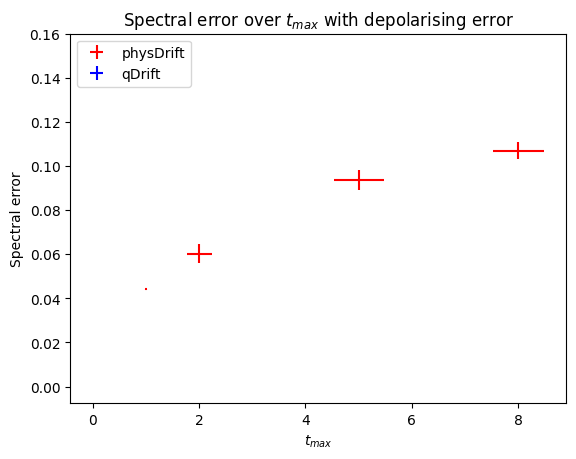

In [89]:
plt.errorbar([0]+t_list,um_spec_mean ,yerr=um_spec_std, xerr=extract_depth_at_t(t_list,[mdepth[0][0],mdepth[1][0],mdepth[2][0]]), label='physDrift',ls='none',c='r')
plt.errorbar([0]+t_list,uq_spec_mean ,yerr=uq_spec_std, xerr=extract_depth_at_t(t_list,[qdepth[0][0],qdepth[1][0],qdepth[2][0]]), label='qDrift',ls='none',c='b')
plt.title(r'Spectral error over $t_{max}$ with depolarising error')
plt.xlabel(r'$t_{max}$')
plt.ylabel('Spectral error') 
plt.legend()

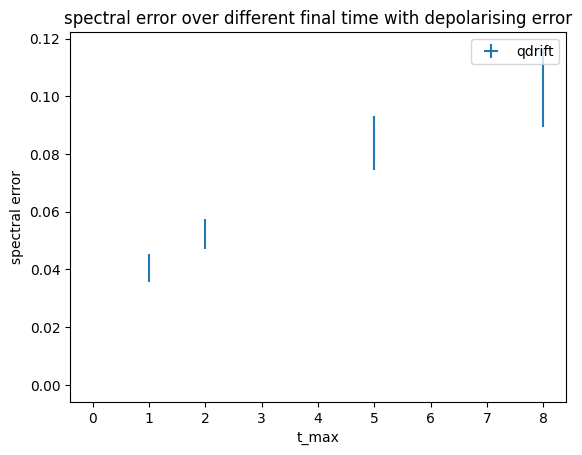

In [ ]:
plt.errorbar([0]+t_list,uuq_mean ,yerr=uuq_std, xerr=extract_depth_at_t(t_list,qdepth), label='qdrift',ls='none')
plt.title('spectral error over different final time with depolarising error')
plt.xlabel('t_max')
plt.ylabel('spectral error') 
plt.legend()

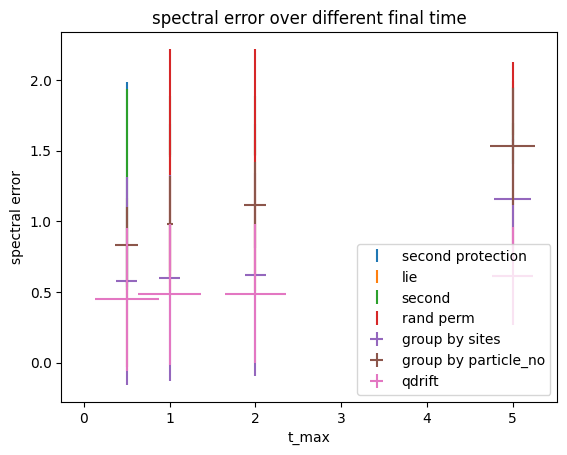

In [ ]:
# plt.scatter([0]+t_list,u2p_m,label='second protection')
# plt.scatter([0]+t_list,ut_m,label='lie')
# plt.scatter([0]+t_list,u2_m,label='second')
# plt.scatter([0]+t_list,urp_m,label='rand perm')
# plt.scatter([0]+t_list,m_noise_mean,label='group by sites')
# plt.scatter([0]+t_list,g_noise_mean,label='group by particle_no')
# plt.scatter([0]+t_list,q_noise_mean,label='qdrift')
plt.errorbar([0]+t_list,u2p_m ,yerr=u2p_s,label='second protection',ls='none')
plt.errorbar([0]+t_list,ut_m ,yerr=ut_s,label='lie',ls='none')
plt.errorbar([0]+t_list,u2_m ,yerr=u2_s,label='second',ls='none')
plt.errorbar([0]+t_list,urp_m ,yerr=urp_s,label='rand perm',ls='none')
plt.errorbar([0]+t_list,m_noise_mean ,yerr=m_noise_std, xerr=m_noise_std_x, label='group by sites',ls='none')
plt.errorbar([0]+t_list,g_noise_mean ,yerr=g_noise_std, xerr=g_noise_std_x, label='group by particle_no',ls='none')
plt.errorbar([0]+t_list,q_noise_mean ,yerr=q_noise_std, xerr=q_noise_std_x, label='qdrift',ls='none')
plt.title('spectral error over different final time')
plt.xlabel('t_max')
plt.ylabel('spectral error') 
plt.legend()